In [1]:
pip install yfinance pandas matplotlib backtrader


Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Get historical data for SPY
ticker = yf.Ticker("SPY")
spy_data = ticker.history(period="5y")  # Get 5 years of data

# Get options chain for SPY
expiration = ticker.options[0]  # Get the first available expiration date
options_chain = ticker.option_chain(expiration)
calls = options_chain.calls
puts = options_chain.puts

# Preview the SPY data and options chain
print(spy_data.head())
print(calls.head())


                                 Open        High         Low       Close  \
Date                                                                        
2019-10-09 00:00:00-04:00  269.145389  270.580203  268.506658  269.626740   
2019-10-10 00:00:00-04:00  269.543482  272.348333  269.376864  271.450409   
2019-10-11 00:00:00-04:00  274.255230  276.541694  274.134913  274.264496   
2019-10-14 00:00:00-04:00  273.940483  274.625515  273.607247  273.959015   
2019-10-15 00:00:00-04:00  275.023592  277.430401  274.903247  276.671326   

                             Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                         
2019-10-09 00:00:00-04:00  62359400        0.0           0.0            0.0  
2019-10-10 00:00:00-04:00  55296300        0.0           0.0            0.0  
2019-10-11 00:00:00-04:00  98720400        0.0           0.0            0.0  
2019-10-14 00:00:00-04:00  40394800        0.0           0.0          

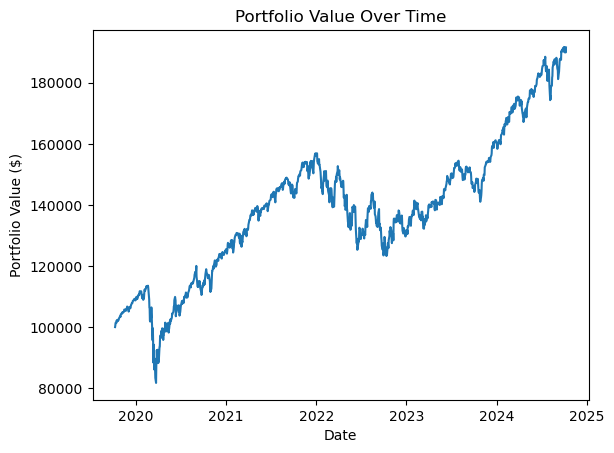

In [6]:
import numpy as np

# Set initial capital
capital = 100000
spy_shares = 0
leaps_contracts = 0
portfolio_value = []

# Iterate through the historical SPY data to simulate the strategy
for date, row in spy_data.iterrows():
    # Simulate buying LEAPs at the start
    if leaps_contracts == 0:
        # Assume buying LEAPs when the SPY price drops below a certain threshold
        if row['Close'] < 0.8 * spy_data['Close'].max():  # Arbitrary condition to enter
            leaps_contracts = capital // (row['Close'] * 100)  # LEAPs cost like 100 shares of SPY
            capital -= leaps_contracts * row['Close'] * 100  # Deduct capital for LEAP purchase

    # Simulate selling covered calls every month
    if leaps_contracts > 0:
        # If it's time to sell a covered call (e.g., every 30 days)
        if (date - spy_data.index[0]).days % 30 == 0:
            # Sell a covered call and collect premium
            premium = 0.01 * row['Close']  # Arbitrary premium calculation
            capital += premium * leaps_contracts  # Add premium to capital

    # Track portfolio value
    portfolio_value.append(capital + leaps_contracts * row['Close'] * 100)

# Plot portfolio value over time
plt.plot(spy_data.index, portfolio_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()


In [10]:
def find_leaps(options_chain, min_moneyness=0.8, max_moneyness=0.9, expiry_days=730):
    # Moneyness is a proxy for delta: Deep ITM options will have high deltas
    leaps = options_chain.calls[
        (options_chain.calls['strike'] <= min_moneyness * spy_data['Close'].iloc[-1]) & 
        (options_chain.calls['strike'] >= max_moneyness * spy_data['Close'].iloc[-1])
    ]
    return leaps

def sell_covered_call(options_chain, min_moneyness=1.05):
    # Sell covered call based on strike being OTM (moneyness > 1)
    calls = options_chain.calls[
        (options_chain.calls['strike'] > min_moneyness * spy_data['Close'].iloc[-1])
    ]
    return calls

# Example usage with updated functions
leaps = find_leaps(options_chain, min_moneyness=0.8, max_moneyness=0.9)
covered_call = sell_covered_call(options_chain, min_moneyness=1.05)

# Display results
print("LEAPS:", leaps.head())
print("Covered Call:", covered_call.head())


LEAPS: Empty DataFrame
Columns: [contractSymbol, lastTradeDate, strike, lastPrice, bid, ask, change, percentChange, volume, openInterest, impliedVolatility, inTheMoney, contractSize, currency]
Index: []
Covered Call:         contractSymbol             lastTradeDate  strike  lastPrice  bid  \
65  SPY241008C00605000 2024-10-03 15:47:26+00:00   605.0       0.01  0.0   
66  SPY241008C00610000 2024-09-30 18:32:53+00:00   610.0       0.01  0.0   
67  SPY241008C00615000 2024-10-03 18:04:49+00:00   615.0       0.01  0.0   
68  SPY241008C00620000 2024-09-30 14:55:14+00:00   620.0       0.01  0.0   
69  SPY241008C00625000 2024-09-26 20:09:10+00:00   625.0       0.03  0.0   

     ask  change  percentChange  volume  openInterest  impliedVolatility  \
65  0.01     0.0            0.0     1.0           791           0.375006   
66  0.01     0.0            0.0     3.0             6           0.421881   
67  0.01     0.0            0.0   198.0           344           0.476568   
68  0.01     0.0      

In [22]:
last_call_sell_date = None  # Track the last date when a covered call was sold
portfolio_value = []  # Reset portfolio value list

for date, row in spy_data.iterrows():
    # At specific points, look for LEAPs to buy
    if leaps_contracts == 0:
        leaps = find_leaps(options_chain)
        if not leaps.empty:
            leap_contract = leaps.iloc[0]
            leaps_contracts = capital // (leap_contract['lastPrice'] * 100)
            capital -= leaps_contracts * leap_contract['lastPrice'] * 100
            print(f"Bought LEAP contract: {leap_contract['contractSymbol']} on {date}")

    # Monthly selling of covered calls
    if leaps_contracts > 0:
        if last_call_sell_date is None or date.month != last_call_sell_date.month:  # Sell covered call only once per month
            covered_calls = sell_covered_call(options_chain)
            if not covered_calls.empty:
                covered_call = covered_calls.iloc[0]
                premium = covered_call['lastPrice']
                capital += premium * leaps_contracts * 100
                print(f"Sold covered call: {covered_call['contractSymbol']} on {date}")
                last_call_sell_date = date  # Update the last call sell date
    
    # Update portfolio value exactly once per day (or time step)
    portfolio_value.append(capital + leaps_contracts * row['Close'] * 100)

# Output the starting and final portfolio values
starting_value = portfolio_value[0] if portfolio_value else capital
ending_value = portfolio_value[-1] if portfolio_value else capital

print(f"Starting portfolio value: ${starting_value:.2f}")
print(f"Final portfolio value: ${ending_value:.2f}")


Sold covered call: SPY241008C00605000 on 2019-10-09 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2019-11-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2019-12-02 00:00:00-05:00
Sold covered call: SPY241008C00605000 on 2020-01-02 00:00:00-05:00
Sold covered call: SPY241008C00605000 on 2020-02-03 00:00:00-05:00
Sold covered call: SPY241008C00605000 on 2020-03-02 00:00:00-05:00
Sold covered call: SPY241008C00605000 on 2020-04-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-05-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-06-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-07-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-08-03 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-09-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-10-01 00:00:00-04:00
Sold covered call: SPY241008C00605000 on 2020-11-02 00:00:00-05:00
Sold covered call: SPY241008C00605000 on 2020-12-01 00:00:00-0

In [24]:
# Profit Difference: $91,242.98
# Percentage Difference: 81.56%
# So, over the 5-year period, your portfolio increased by approximately 81.56%. ​
# 